# LSTM

In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow

from numpy import *
from math import sqrt
from pandas import *

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot
from pickle import load

In [351]:
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

In [352]:
#Parameters

LR = 0.001
BATCH_SIZE = 64
N_EPOCH = 50


input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [353]:
def basic_lstm(input_dim, feature_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units= 128), input_shape=(input_dim, feature_size)))
    model.add(Dense(2048))
    model.add(Dropout(0.5))
    model.add(Dense(2048))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr = LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return model

Epoch 1/50
5/5 - 1s - loss: 6.8742 - val_loss: 0.3428
Epoch 2/50
5/5 - 0s - loss: 1.7566 - val_loss: 0.4009
Epoch 3/50
5/5 - 0s - loss: 0.4634 - val_loss: 0.6963
Epoch 4/50
5/5 - 0s - loss: 0.4367 - val_loss: 0.0818
Epoch 5/50
5/5 - 0s - loss: 0.4179 - val_loss: 0.0365
Epoch 6/50
5/5 - 0s - loss: 0.0733 - val_loss: 0.0470
Epoch 7/50
5/5 - 0s - loss: 0.1409 - val_loss: 0.0533
Epoch 8/50
5/5 - 0s - loss: 0.0515 - val_loss: 0.0697
Epoch 9/50
5/5 - 0s - loss: 0.0407 - val_loss: 0.0381
Epoch 10/50
5/5 - 0s - loss: 0.0289 - val_loss: 0.0465
Epoch 11/50
5/5 - 0s - loss: 0.0299 - val_loss: 0.0407
Epoch 12/50
5/5 - 0s - loss: 0.0234 - val_loss: 0.0454
Epoch 13/50
5/5 - 0s - loss: 0.0180 - val_loss: 0.0433
Epoch 14/50
5/5 - 0s - loss: 0.0196 - val_loss: 0.0448
Epoch 15/50
5/5 - 0s - loss: 0.0185 - val_loss: 0.0484
Epoch 16/50
5/5 - 0s - loss: 0.0168 - val_loss: 0.0457
Epoch 17/50
5/5 - 0s - loss: 0.0162 - val_loss: 0.0444
Epoch 18/50
5/5 - 0s - loss: 0.0176 - val_loss: 0.0446
Epoch 19/50
5/5 - 0

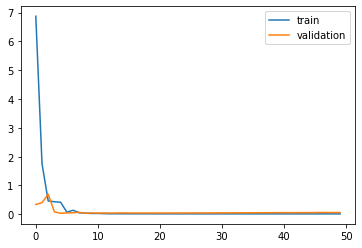

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_56 (Bidirectio (None, 256)               135168    
_________________________________________________________________
dense_168 (Dense)            (None, 2048)              526336    
_________________________________________________________________
dropout_56 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_169 (Dense)            (None, 2048)              4196352   
_________________________________________________________________
dense_170 (Dense)            (None, 1)                 2049      
Total params: 4,859,905
Trainable params: 4,859,905
Non-trainable params: 0
_________________________________________________________________
None
0.24945775687612814


In [354]:
model = basic_lstm(input_dim, feature_size)
model.save('LSTM_30to1.h5')
print(model.summary())

yhat = model.predict(X_test, verbose=0)
#print(yhat)

rmse = sqrt(mean_squared_error(y_test, yhat))
print(rmse)

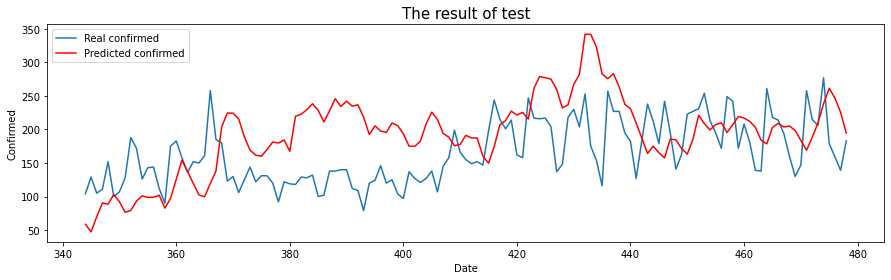

-- RMSE --  68.85034112009856
-- MAE -- 57.59358055283212


In [355]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from sklearn.metrics import mean_squared_error, mean_absolute_error


########### Test dataset #########

# Load scaler/ index
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

# Load test dataset/ model
G_model = tf.keras.models.load_model('LSTM_30to1.h5')
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)


def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    #drop 2020
    # Input_Before = '2020-01-01'
    # predict_result = predict_result.loc[predict_result.index < Input_Before]
    # real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    plt.figure(figsize=(15, 4))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Confirmed")
    plt.legend(("Real confirmed", "Predicted confirmed"), loc="upper left", fontsize=10)
    plt.title("The result of test", fontsize=15)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    MAE = mean_absolute_error(predicted, real)
    # accuracy = accuracy_score(predicted, real)
    print('-- RMSE -- ', RMSE)
    print('-- MAE --', MAE)
    #print('-- accuracy --', accuracy)

    return predict_result, RMSE, MAE


test_predicted, test_RMSE, test_MAE = get_test_plot(X_test, y_test)